In [8]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

print("Hello world.")

Hello world.


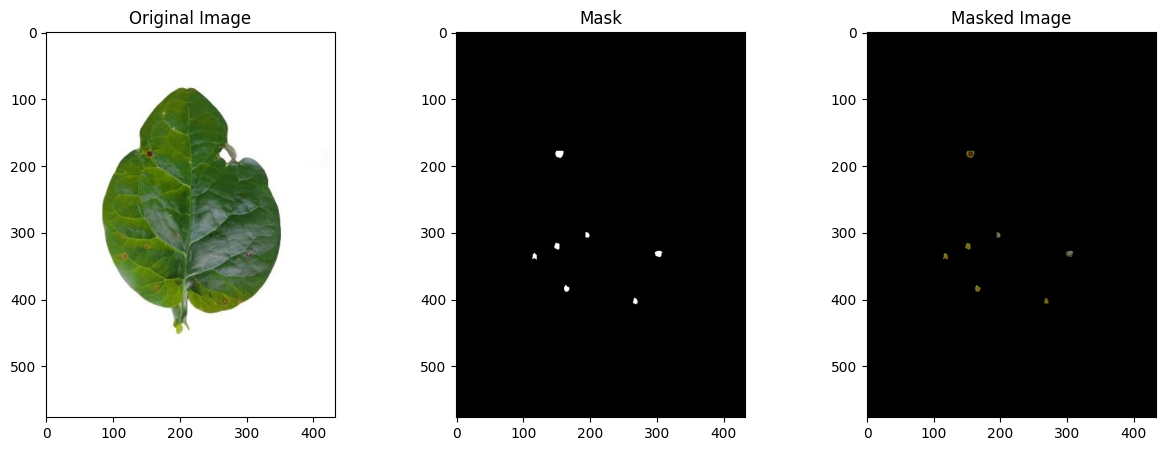

In [9]:


image_path = r"/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)/Bacterial-Spot (50).jpg"
image = cv2.imread(image_path)

json_path = r"/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region/Bacterial-Spot (50).json"
with open(json_path, 'r') as file:
    data = json.load(file)

# Create a blank mask with the same dimensions as the input image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

if 'shapes' in data:
    for annotation in data['shapes']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
elif 'annotations' in data:
    for annotation in data['annotations']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
else:
    print("No valid keys ('shapes' or 'annotations') found in JSON.")

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Display the original image, mask, and masked image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Masked Image")
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.show()

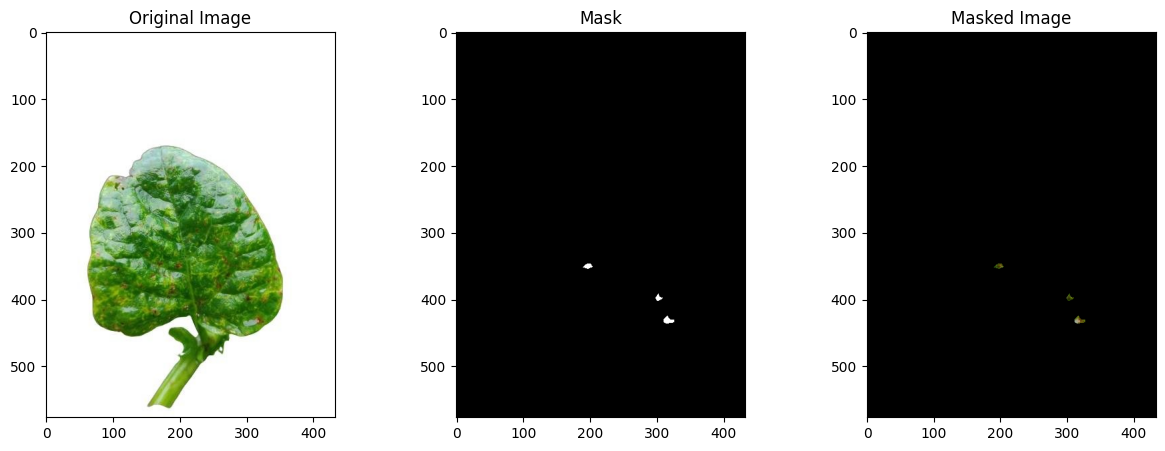

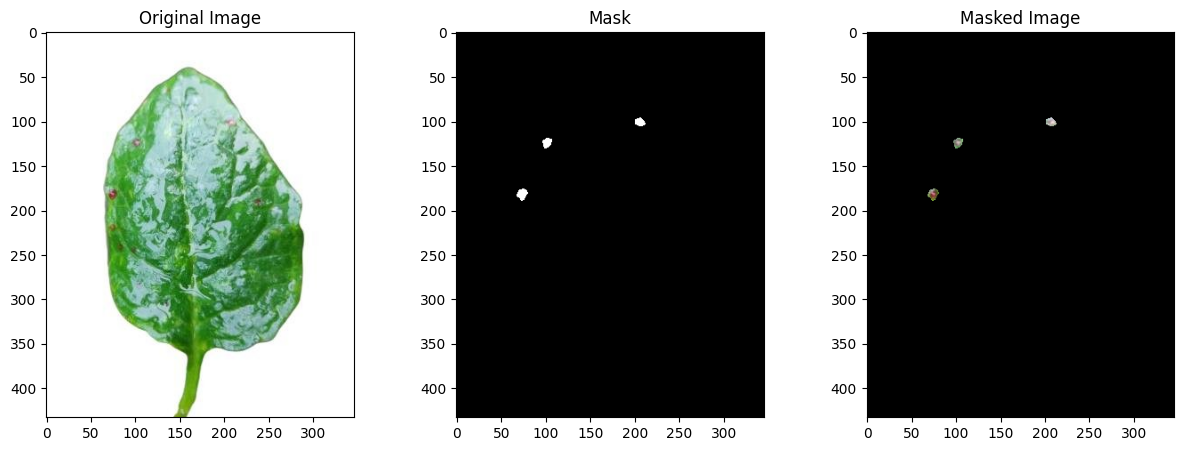

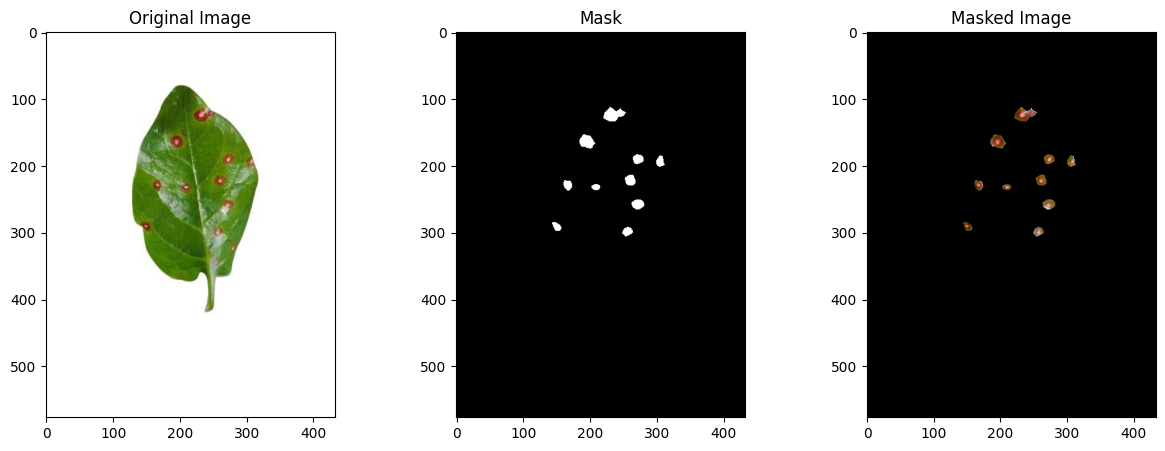

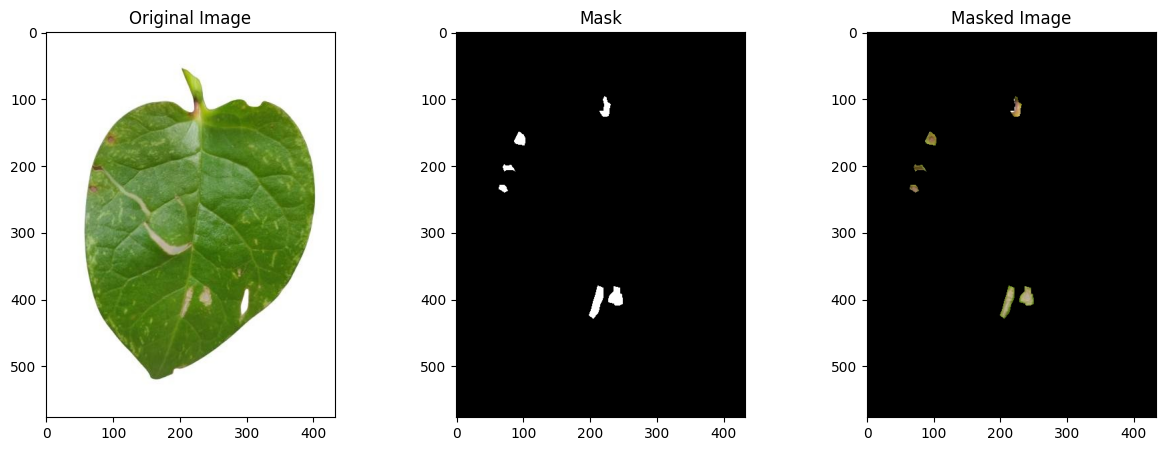

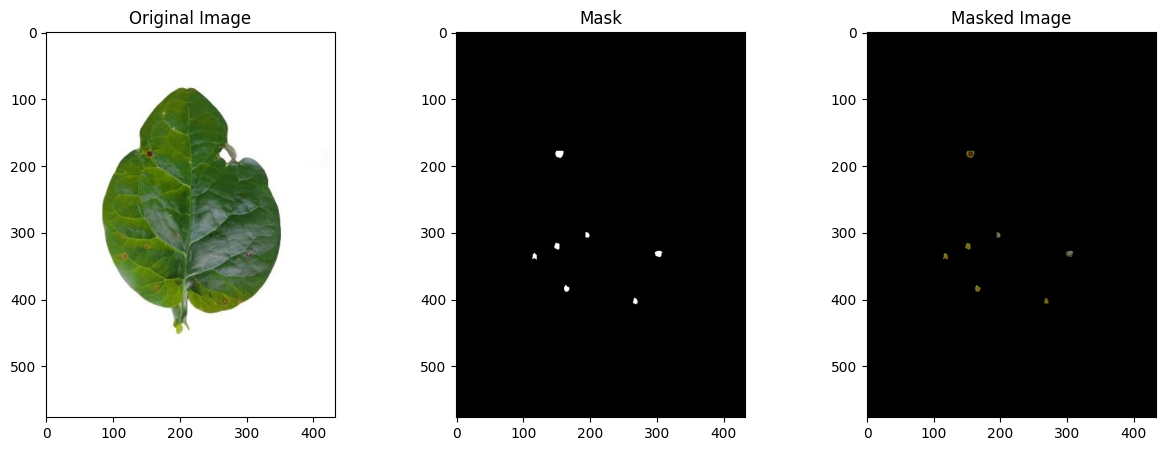

In [10]:
i = 0 
image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)"
json_path = "/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region"
for i in range(45, 50):
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    #print(image_name)
    #print(json_file_name)
    image = cv2.imread(image_path+'/'+image_name)
    json_file = json_path + '/' + json_file_name
    #print(json_file)

    with open(json_file, 'r') as file:
        data = json.load(file)

    # Create a blank mask with the same dimensions as the input image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    if 'shapes' in data:
        for annotation in data['shapes']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    elif 'annotations' in data:
        for annotation in data['annotations']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    else:
        print("No valid keys ('shapes' or 'annotations') found in JSON.")

    masked_image = cv2.bitwise_and(image, image, mask=mask)


    # Display the original image, mask, and masked image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Masked Image")
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

    plt.show()




In [11]:
def create_mask(json_file, image_shape):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    for shape in data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    
    return mask


train_images, valid_images, test_images = [], [], []
train_masks, valid_masks, test_masks = [], [], []

for i in range(0, 50):

    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    json_file = json_path + '/' + json_file_name
    
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    image = cv2.imread(image_path+'/'+image_name)
    if image is None:
        continue
    
    mask = create_mask(json_file, image.shape)
    
    # Save mask
    #mask_path = os.path.join(mask_dir, f'mask_{i+1}.png')
    #cv2.imwrite(mask_path, mask)
    
    if i < 40:
        train_images.append(image)
        train_masks.append(mask)
    elif i < 45:
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)


print("Hello world.")

Hello world.


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet_model = build_unet()
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 384)              │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │    442,496 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0] 

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array

# Prepare datasets
X_train, y_train = preprocess_data(train_images, train_masks)
X_valid, y_valid = preprocess_data(valid_images, valid_masks)
X_test, y_test = preprocess_data(test_images, test_masks)

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

# Train the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9950 - loss: 0.4003
Epoch 1: val_loss improved from inf to 0.15344, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 565ms/step - accuracy: 0.9951 - loss: 0.3744 - val_accuracy: 0.9937 - val_loss: 0.1534
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9965 - loss: 0.0574
Epoch 2: val_loss improved from 0.15344 to 0.04064, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.9965 - loss: 0.0550 - val_accuracy: 0.9937 - val_loss: 0.0406
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9964 - loss: 0.0354
Epoch 3: val_loss did not improve from 0.04064
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.9964 - loss: 0.0345 - val_accuracy: 0.9937 - val_loss: 0.0511
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9967 - loss: 0.0281
Epoch 4: val_loss improved from 0.04064 to 0.03829, saving model to unet_best_model.keras
5/5 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


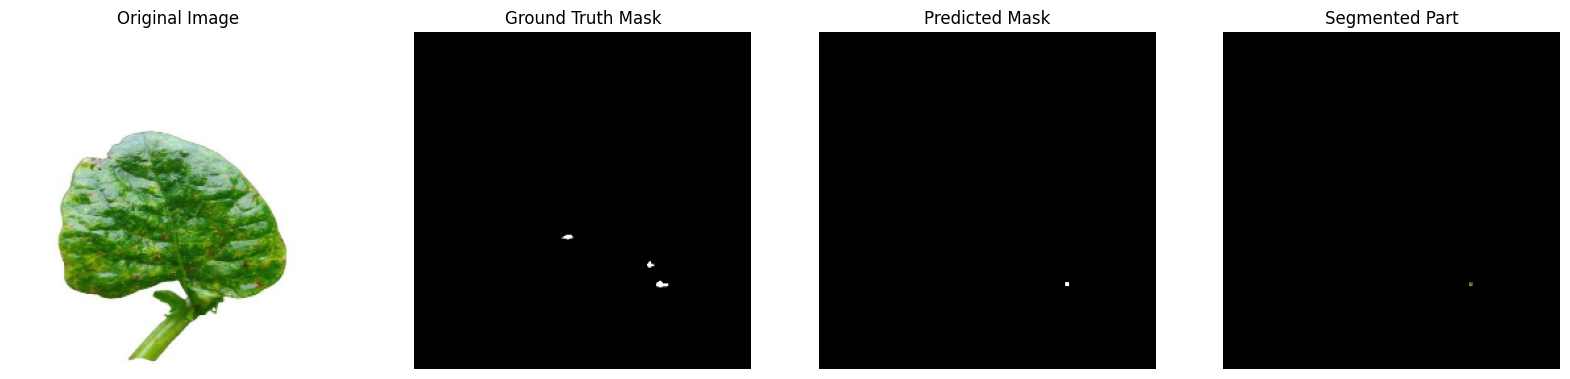

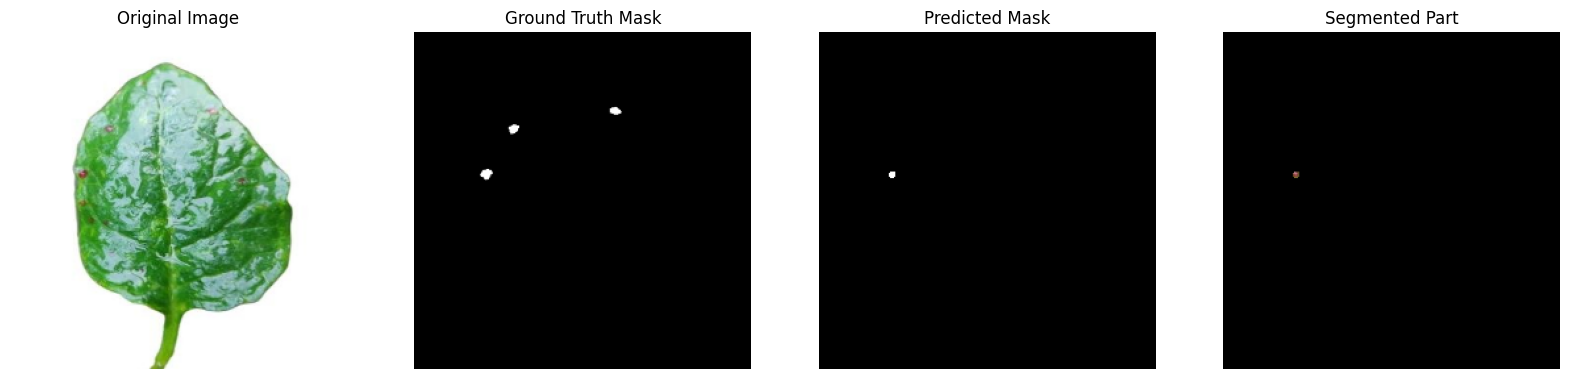

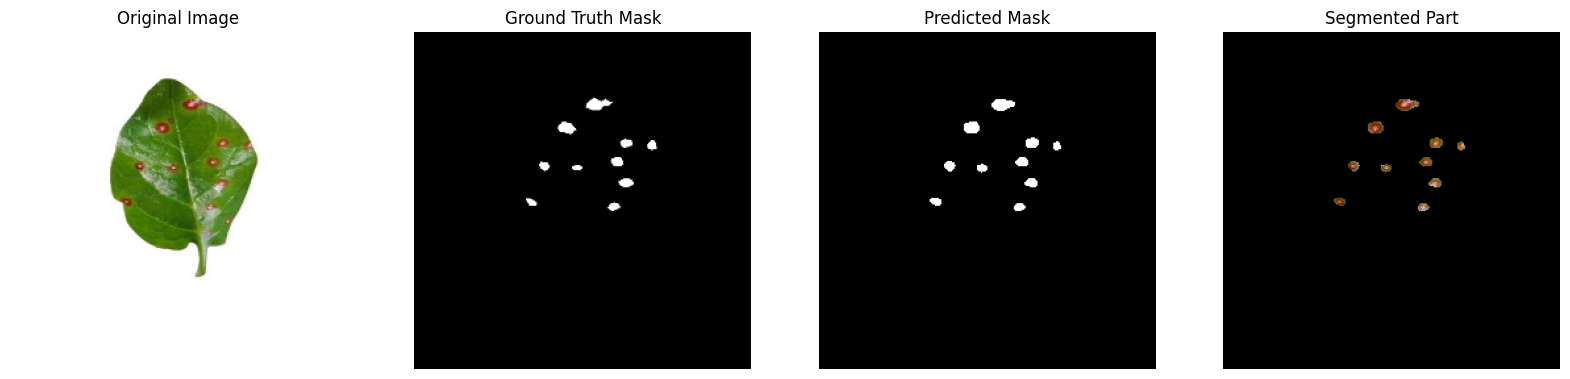

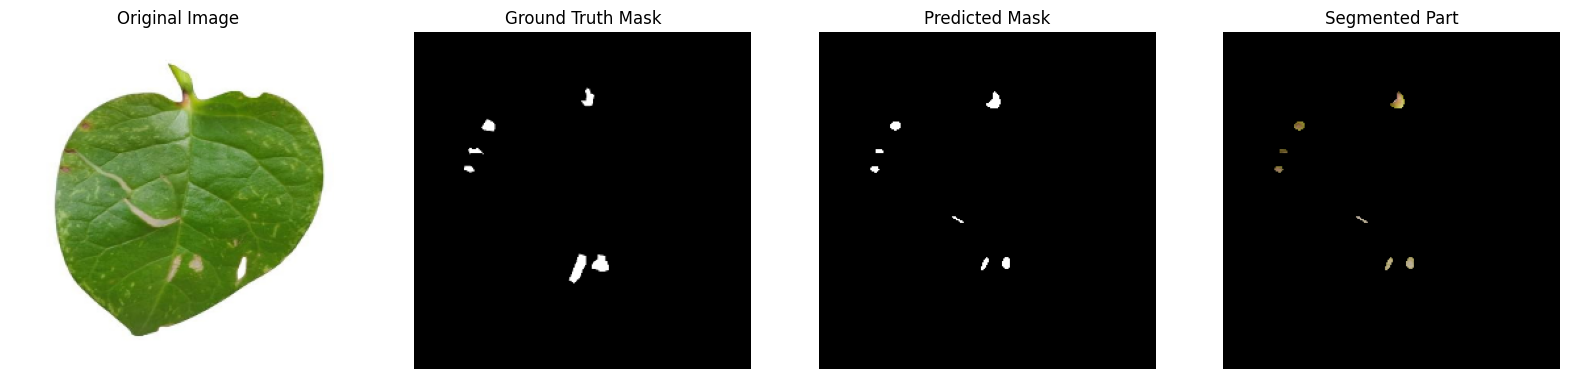

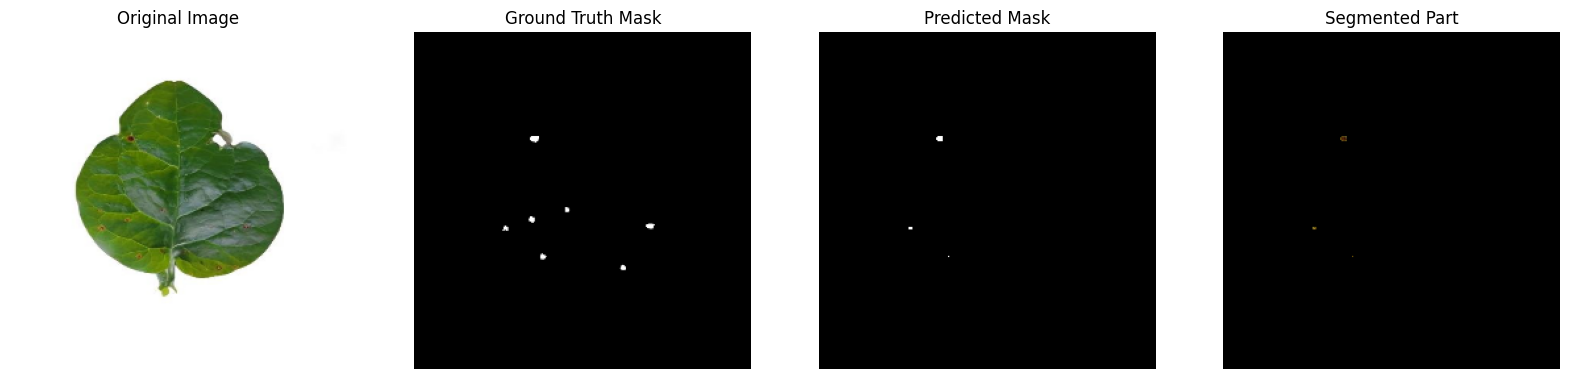

In [14]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Load model and predict
best_model = load_model("/kaggle/working/unet_best_model.keras")
predictions = best_model.predict(X_test)

# Create masks from predictions
predicted_masks = create_mask(predictions)

def get_segmented_image(image, mask):
    # Ensure both are uint8 and mask is single channel
    image_uint8 = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image
    mask_uint8 = (mask.squeeze() * 255).astype(np.uint8)
    
    # Ensure mask is 2D
    if mask_uint8.ndim == 3:
        mask_uint8 = mask_uint8[..., 0]

    # Apply mask using bitwise_and
    segmented = cv2.bitwise_and(image_uint8, image_uint8, mask=mask_uint8)
    return segmented

def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        img = images[i]
        true_mask = masks[i]
        predicted_mask = predictions[i]
        segmented_img = get_segmented_image(img, predicted_mask)

        plt.figure(figsize=(20, 5))  # wider figure for 4 plots

        # 1. Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # 2. Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # 3. Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # 4. Segmented Part
        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Part')
        plt.axis('off')

        plt.show()

# Visualize results
visualize_results(X_test, y_test, predicted_masks, num_images=5)



# Save predicted masks and segmented images
def save_masks_and_segmented(images, masks, output_dir):
    masks_dir = os.path.join(output_dir, "predicted_masks")
    segmented_dir = os.path.join(output_dir, "segmented_images")
    
    os.makedirs(masks_dir, exist_ok=True)
    os.makedirs(segmented_dir, exist_ok=True)
    
    for i, (img, mask) in enumerate(zip(images, masks)):
        # Convert to proper format
        img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        mask_uint8 = (mask.squeeze() * 255).astype(np.uint8)
        
        # Save predicted mask
        mask_path = os.path.join(masks_dir, f"pred_mask_{i}.png")
        cv2.imwrite(mask_path, mask_uint8)
        
        # Create segmented image
        segmented_img = get_segmented_image(img_uint8, mask)
        
        # Ensure color format before saving
        segmented_bgr = segmented_img
        #segmented_bgr = cv2.cvtColor(segmented_img , cv2.COLOR_RGB2BGR)
        segmented_path = os.path.join(segmented_dir, f"segmented_{i}.png")
        cv2.imwrite(segmented_path, segmented_bgr)


save_masks_and_segmented(X_test, predicted_masks, output_dir="/kaggle/working/output")

In [ ]:


while(True):
    continue
